In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import pandas as pd
import numpy as np

import math
import copy

In [6]:
fileroot='2024_03_08_TRF_Maleen/'
filename='2024_03_08_TRF_Maleen_01'

datapath='/home/maleen/rosbags/Transformers/datasets/training/'

# Load the DataFrame from the pickle file
df1 = pd.read_pickle(datapath + filename + '.pkl')

arrays = [np.array(item) for item in df1['Skeleton_3D']]

# Stack these arrays along a new axis to create a 3D NumPy array
# Each "slice" of this 3D array represents one frame of keypoints
skeleton_3d_frames = np.stack(arrays, axis=0)


In [7]:
#Create masks for the data (1 = data present, 0 = data missing)
# Correcting the mask values
masks = np.where(np.isnan(skeleton_3d_frames).any(axis=2), 0, 1)  # 0 for missing, 1 for present

In [8]:
# Initialize arrays to hold the normalized data, means, and standard deviations
normalized_skeleton = np.empty_like(skeleton_3d_frames)
means_per_joint_axis = np.empty((skeleton_3d_frames.shape[1], skeleton_3d_frames.shape[2]))
stds_per_joint_axis = np.empty((skeleton_3d_frames.shape[1], skeleton_3d_frames.shape[2]))

# Iterate over each joint and each axis
for joint in range(skeleton_3d_frames.shape[1]):  # For each joint
    for axis in range(skeleton_3d_frames.shape[2]):  # For each axis (x, y, z)
        joint_axis_data = skeleton_3d_frames[:, joint, axis]
        mask_for_joint = masks[:, joint]

        # Select valid data based on the mask
        valid_data = joint_axis_data[mask_for_joint == 1]
        
        # Calculate mean and standard deviation for valid data
        mean = np.mean(valid_data) if valid_data.size > 0 else np.nan
        std = np.std(valid_data) if valid_data.size > 0 else np.nan

        # Store the calculated means and standard deviations
        means_per_joint_axis[joint, axis] = mean
        stds_per_joint_axis[joint, axis] = std

        # Normalize the data, avoiding division by zero
        if std > 0:
            normalized_values = (joint_axis_data - mean) / std
        else:
            normalized_values = joint_axis_data  # Keep original values if std is 0 or nan

        # Apply normalization only where data is present
        normalized_skeleton[:, joint, axis] = np.where(mask_for_joint == 1, normalized_values, np.nan)

# The 'normalized_skeleton' array now contains the normalized data
# 'means_per_joint_axis' and 'stds_per_joint_axis' contain the means and standard deviations used for normalization


array([[0.16871058, 0.48956976, 0.02523488],
       [0.16183731, 0.49908079, 0.01563293],
       [0.15503894, 0.49728771, 0.01760015],
       [0.17732509, 0.48938397, 0.05811919],
       [0.18839268, 0.45744669, 0.15823954],
       [0.18943464, 0.47090428, 0.01913931],
       [0.23017625, 0.47975959, 0.04879799],
       [0.25270668, 0.4467623 , 0.1261652 ],
       [0.14266476, 0.48006159, 0.02832932],
       [0.07764552, 0.45178494, 0.0298921 ],
       [       nan,        nan,        nan],
       [0.16954209, 0.47949283, 0.01758971],
       [0.12136637, 0.39183999, 0.03711026],
       [       nan,        nan,        nan],
       [0.16322439, 0.49323824, 0.02390038],
       [0.17328477, 0.4954552 , 0.02532111],
       [0.15577046, 0.51373122, 0.02081212],
       [0.15632331, 0.46450587, 0.01866508]])

/tmp/ipykernel_16224/3539762763.py:5: RuntimeWarning: Mean of empty slice
  means_after_normalization = np.nanmean(normalized_skeleton, axis=0)
/home/maleen/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


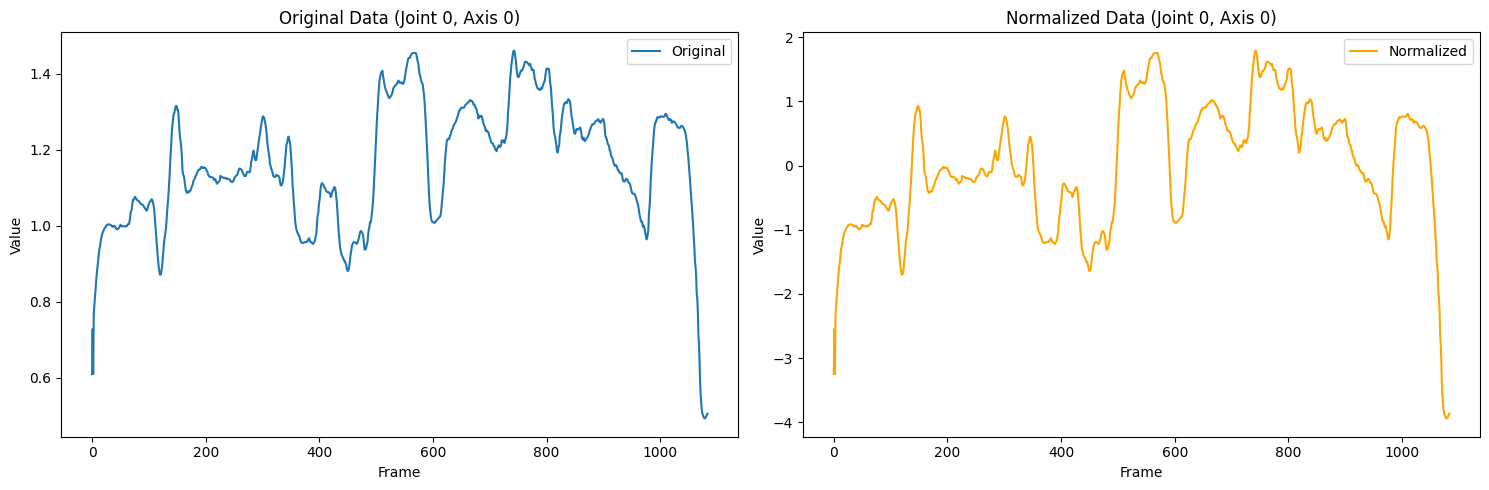

(array([[ 6.51385465e-16,  1.49531883e-16, -9.38158940e-17],
        [ 7.00956308e-16,  3.41055597e-17,  1.79847936e-16],
        [ 1.31123834e-16, -3.52962269e-16, -2.71319127e-16],
        [ 1.31506122e-16,  1.25975491e-17, -1.38265783e-16],
        [ 2.04131063e-17, -1.82364026e-16,  5.18594444e-17],
        [-1.27412782e-16,  2.00293717e-16,  2.89049709e-16],
        [-8.18168087e-16, -2.29812023e-16,  1.41159886e-16],
        [ 5.07771518e-16,  3.20625662e-16,  1.81663274e-16],
        [ 8.07284846e-16, -7.38772942e-17, -9.04274590e-16],
        [-1.25455202e-15, -7.19662425e-17, -3.14827529e-16],
        [            nan,             nan,             nan],
        [-1.76311280e-16,  1.00158051e-16,  1.17706404e-15],
        [ 7.73601731e-16,  2.06441894e-16,  7.63147653e-16],
        [            nan,             nan,             nan],
        [-1.15938419e-16, -4.20123141e-16,  5.26434165e-16],
        [-4.17869921e-17,  4.91406833e-16, -6.75966048e-17],
        [ 3.79360340e-16

In [19]:
stds_after_normalization

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [nan, nan, nan],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [nan, nan, nan],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])